In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics.classification import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.regression import r2_score, mean_squared_error, mean_absolute_error

#If Tensorflow
from dbn.tensorflow import SupervisedDBNRegression
#If Numpy
#from dbn.tensorflow import SupervisedDBNRegression

In [24]:
RBM_EPOCHS = 2
DBN_EPOCHS = 5
RBM_LEARNING_RATE = 0.01
DBN_LEARNING_RATE = 0.01
HIDDEN_LAYER_STRUCT = [5, 10, 15]
ACTIVE_FUNC = 'relu'
BATCH_SIZE = 28

In [2]:
# Read the dataset
ROAD = "Taft Ave."
YEAR = "2015"
EXT = ".csv"
WINDOWSIZE = 4
TRANSFORMED = True
DIR = "../../../datasets/Thesis Datasets/mmda/"

if TRANSFORMED:
    FILENAME = "eng_win" + str(WINDOWSIZE) + "_mmda_" + ROAD + "_" + YEAR + "_transformed"
else:
    FILENAME = "eng_win" + str(WINDOWSIZE) + "_mmda_" + ROAD + "_" + YEAR 

In [3]:
original_dataset = pd.read_csv(DIR + FILENAME + EXT, skipinitialspace=True)
original_dataset = original_dataset.fillna(0)
original_dataset.head()

,dt,lineName,stationName,statusN,statusS,statusN_Emean,statusN_Emin,statusN_Emax,statusN_Esum,statusN_Rmean (window = 4),statusN_Rmin (window = 4),statusN_Rmax (window = 4),statusS_Emean,statusS_Emin,statusS_Emax,statusS_Esum,statusS_Rmean (window = 4),statusS_Rmin (window = 4),statusS_Rmax (window = 4)
0,01/01/2015 0:00,EDSA,Taft Ave.,0.231394,0.408168,0.231394,0.231394,0.231394,0.231394,0.000000,0.0,0.000000,0.408168,0.408168,0.408168,0.408168,0.000000,0.0,0.000000
1,01/01/2015 0:15,EDSA,Taft Ave.,0.237548,0.407201,0.234471,0.231394,0.237548,0.468942,0.000000,0.0,0.000000,0.407685,0.407201,0.408168,0.815369,0.000000,0.0,0.000000
2,01/01/2015 0:30,EDSA,Taft Ave.,0.243492,0.406253,0.237478,0.231394,0.243492,0.712434,0.000000,0.0,0.000000,0.407207,0.406253,0.408168,1.221622,0.000000,0.0,0.000000
3,01/01/2015 0:45,EDSA,Taft Ave.,0.249231,0.405322,0.240416,0.231394,0.249231,0.961665,0.057849,0.0,0.231394,0.406736,0.405322,0.408168,1.626944,0.102042,0.0,0.408168
4,01/01/2015 1:00,EDSA,Taft Ave.,0.254765,0.404408,0.243286,0.231394,0.254765,1.216430,0.117235,0.0,0.468942,0.406270,0.404408,0.408168,2.031352,0.203842,0.0,0.815369


##### Preparing Traffic Dataset

In [4]:
traffic_dataset = pd.read_csv(DIR + FILENAME + EXT, skipinitialspace=True)
traffic_dataset = traffic_dataset.fillna(0)
# Remove date time. Remove unused columms
#0-2 = dt + lineName + stationName || 3-4 - statusN - statusS || 5-14 - original weather variables
#15-46 - engineered traffic
cols_to_remove = [0, 1, 2]

# window 1
statusN = list(range(5, 9))
statusS = list(range(12, 16))

cols_to_remove += statusN + statusS

# window >= 2
statusN2 = list(range(9, 12))
statusS2 = list(range(16, 19))

#cols_to_remove += statusN2 + statusS2

#cols_to_remove += [3, 4] #statusN , statusS

traffic_dataset.drop(traffic_dataset.columns[[cols_to_remove]], axis=1, inplace=True)
traffic_dataset.head()

,statusN,statusS,statusN_Rmean (window = 4),statusN_Rmin (window = 4),statusN_Rmax (window = 4),statusS_Rmean (window = 4),statusS_Rmin (window = 4),statusS_Rmax (window = 4)
0,0.231394,0.408168,0.000000,0.0,0.000000,0.000000,0.0,0.000000
1,0.237548,0.407201,0.000000,0.0,0.000000,0.000000,0.0,0.000000
2,0.243492,0.406253,0.000000,0.0,0.000000,0.000000,0.0,0.000000
3,0.249231,0.405322,0.057849,0.0,0.231394,0.102042,0.0,0.408168
4,0.254765,0.404408,0.117235,0.0,0.468942,0.203842,0.0,0.815369


In [5]:
shift = 1

In [6]:
# To-be Predicted variable 
Y = traffic_dataset.statusS
Y = Y.shift(-shift)
Y = Y.fillna(0)
Y = Y[:-shift]

In [7]:
# Other data
X = traffic_dataset [:-shift]
#X = dataset
#X.statusS = X.statusS.round(5)

# Splitting data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.67, shuffle=False)
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

# Data scaling
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)

In [8]:
# Training
regressor = SupervisedDBNRegression(hidden_layers_structure=[5, 10, 15],
                                    learning_rate_rbm=0.01,
                                    learning_rate=0.01,
                                    n_epochs_rbm=2,
                                    n_iter_backprop=5,
                                    batch_size=28,
                                    activation_function='relu')
regressor.fit(X_train, Y_train)

[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 0.198142
>> Epoch 2 finished 	RBM Reconstruction error 0.171152
>> Epoch 1 finished 	RBM Reconstruction error 0.056649
>> Epoch 2 finished 	RBM Reconstruction error 0.053266
>> Epoch 1 finished 	RBM Reconstruction error 0.024816
>> Epoch 2 finished 	RBM Reconstruction error 0.024656
[END] Pre-training step
[START] Fine tuning step:
>> Epoch 1 finished 	ANN training loss 0.046256
>> Epoch 2 finished 	ANN training loss 0.031797
>> Epoch 3 finished 	ANN training loss 0.030987
>> Epoch 4 finished 	ANN training loss 0.030143
>> Epoch 5 finished 	ANN training loss 0.029201
[END] Fine tuning step


SupervisedDBNRegression()

In [15]:
#To check RBM Loss Errors:
rbm_error = regressor.unsupervised_dbn.rbm_layers[0].rbm_loss_error
print(rbm_error)
#To check DBN Loss Errors
dbn_error = regressor.dbn_loss_error
print(dbn_error)

[0.19814244524139413, 0.17115210323034286, 0.05664889165175256, 0.05326608305362994, 0.024816107998111302, 0.024656082892484756]
[0.04625629241527039, 0.03179732264484892, 0.030986765213555627, 0.030143116083964524, 0.02920066412219293]


In [ ]:
# Test
X_test = min_max_scaler.transform(X_test)
Y_pred = regressor.predict(X_test)
print('Done.\nR-squared: %f\nMSE: %f \nMAE: %f' % (r2_score(Y_test, Y_pred), mean_squared_error(Y_test, Y_pred), mean_absolute_error(Y_test, Y_pred)))

In [ ]:
print(len(Y_pred))
temp = []
for i in range(len(Y_pred)):
    temp.append(Y_pred[i][0])
d = {'Predicted': temp, 'Actual': Y_test}

df = pd.DataFrame(data=d)
df.head()

In [ ]:
df

In [ ]:
## Save the model
regressor.save('models/pm1_' + ROAD + '_' + YEAR + '.pkl')

In [ ]:
df.to_csv("output/pm1_" + FILENAME + EXT, encoding='utf-8')

#### Visualize trend of loss of RBM and DBN Training

In [ ]:
import matplotlib.pyplot as plt

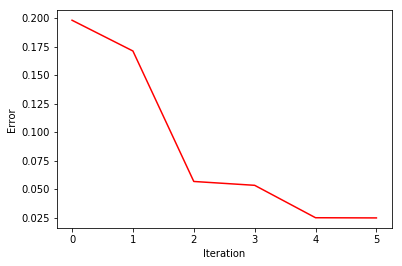

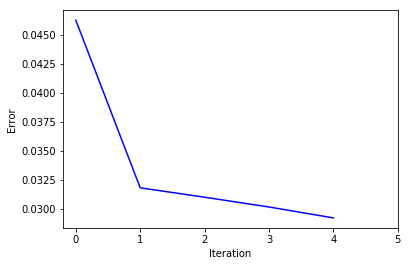

In [35]:
line1 = rbm_error
line2 = dbn_error
x = range(0, RBM_EPOCHS * len(HIDDEN_LAYER_STRUCT))
plt.plot(range(0, RBM_EPOCHS * len(HIDDEN_LAYER_STRUCT)), line1, c='red')
plt.xticks(x)
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.show()

plt.plot(range(DBN_EPOCHS), line2, c='blue')
plt.xticks(x)
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.show()